In [1]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)


NVIDIA A30
(872, 4500, 14) (872,)


# Processing: Mel Spec > Resizing > Feature Extraction

In [2]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [3]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data):
    model.eval()
    x = torch.tensor(data.reshape(-1, 4096), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    loss = []
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            loss.extend(batch_errors.cpu().numpy())
    return np.array(loss)

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    # Step 1: Flatten the test data
    n_samples, n_segments, n_features = X_test.shape
    X_test_flat = X_test.reshape(-1, n_features)

    # Step 2: Compute reconstruction errors per segment
    segment_errors = compute_reconstruction_loss(model, X_test_flat)

    # Step 3: Aggregate errors per sample (mean over segments)
    sample_errors = segment_errors.reshape(n_samples, n_segments).mean(axis=1)

    # Step 4: Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(sample_errors.min(), sample_errors.max(), 100):
        preds = (sample_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Step 5: Predict using best threshold
    test_preds = (sample_errors > best_threshold).astype(int)

    # Step 6: Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))



# Preprocessing

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features = process_dataset_multichannel(scaled_data)
print("Features shape:", features.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 0.920208
Epoch 2/15, Loss: 0.891330
Epoch 3/15, Loss: 0.819231
Epoch 4/15, Loss: 0.677393
Epoch 5/15, Loss: 0.549753
Epoch 6/15, Loss: 0.511399
Epoch 7/15, Loss: 0.503128
Epoch 8/15, Loss: 0.500372
Epoch 9/15, Loss: 0.498845
Epoch 10/15, Loss: 0.498316
Epoch 11/15, Loss: 0.498241
Epoch 12/15, Loss: 0.497709
Epoch 13/15, Loss: 0.497294
Epoch 14/15, Loss: 0.497366
Epoch 15/15, Loss: 0.497179
Best threshold: 0.4849734041425917, Best F1 Score: 0.6382978723404256


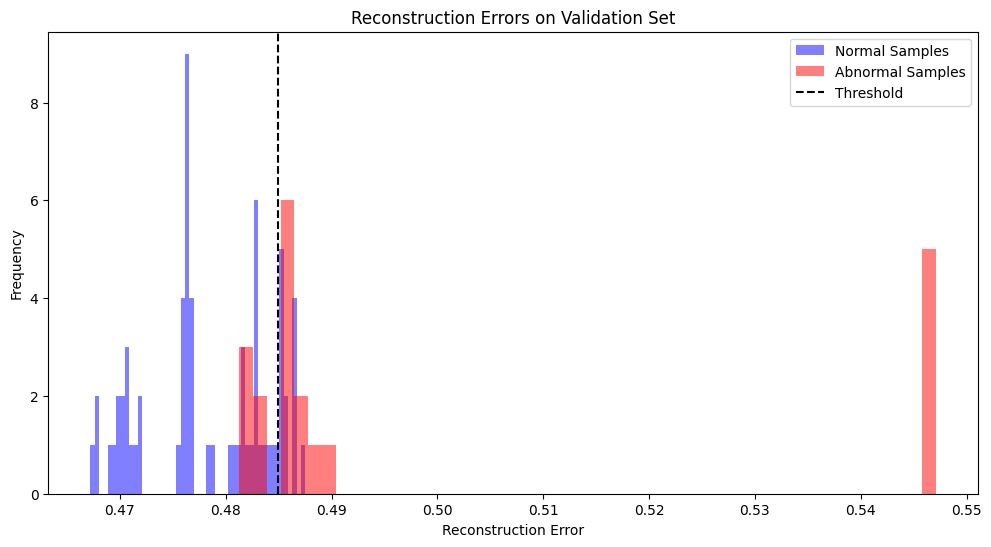

Best Threshold = 0.487186, Best F1 Score = 0.6154
Evaluation on Test Set:
Accuracy = 0.8863636363636364
Precision = 0.8888888888888888
Recall = 0.47058823529411764
F1 Score = 0.6153846153846153
Confusion Matrix:
 [[70  1]
 [ 9  8]]
Fold 2
Epoch 1/15, Loss: 0.917427
Epoch 2/15, Loss: 0.876378
Epoch 3/15, Loss: 0.787483
Epoch 4/15, Loss: 0.642494
Epoch 5/15, Loss: 0.536978
Epoch 6/15, Loss: 0.509587
Epoch 7/15, Loss: 0.503090
Epoch 8/15, Loss: 0.500532
Epoch 9/15, Loss: 0.499275
Epoch 10/15, Loss: 0.498633
Epoch 11/15, Loss: 0.498280
Epoch 12/15, Loss: 0.497985
Epoch 13/15, Loss: 0.497851
Epoch 14/15, Loss: 0.497735
Epoch 15/15, Loss: 0.497540
Best threshold: 0.48546799023946124, Best F1 Score: 0.7692307692307692


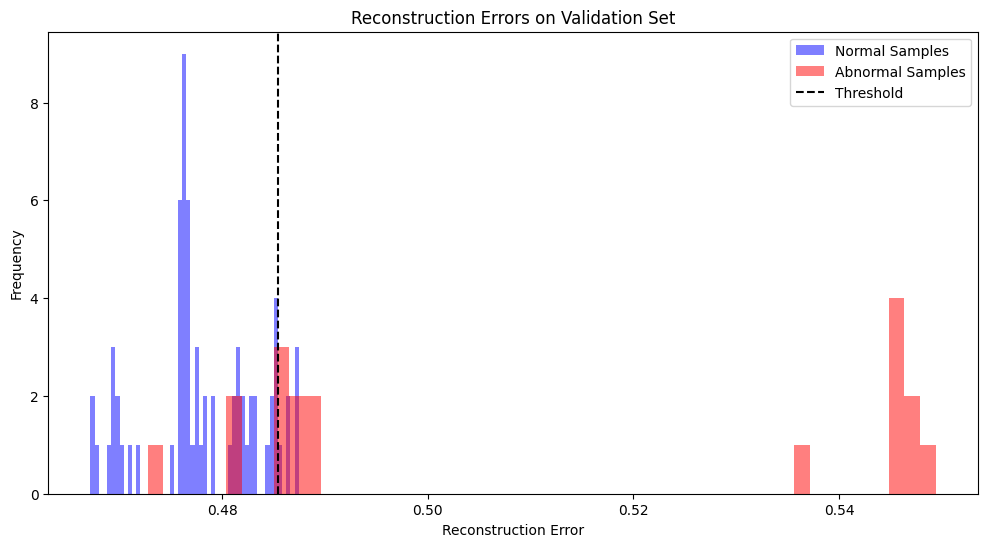

Best Threshold = 0.485854, Best F1 Score = 0.6842
Evaluation on Test Set:
Accuracy = 0.8636363636363636
Precision = 0.6842105263157895
Recall = 0.6842105263157895
F1 Score = 0.6842105263157895
Confusion Matrix:
 [[63  6]
 [ 6 13]]
Fold 3
Epoch 1/15, Loss: 0.920933
Epoch 2/15, Loss: 0.895630
Epoch 3/15, Loss: 0.844518
Epoch 4/15, Loss: 0.745572
Epoch 5/15, Loss: 0.612820
Epoch 6/15, Loss: 0.531286
Epoch 7/15, Loss: 0.508395
Epoch 8/15, Loss: 0.502025
Epoch 9/15, Loss: 0.499551
Epoch 10/15, Loss: 0.498488
Epoch 11/15, Loss: 0.497893
Epoch 12/15, Loss: 0.497593
Epoch 13/15, Loss: 0.497428
Epoch 14/15, Loss: 0.497309
Epoch 15/15, Loss: 0.497269
Best threshold: 0.48780003129833877, Best F1 Score: 0.7333333333333334


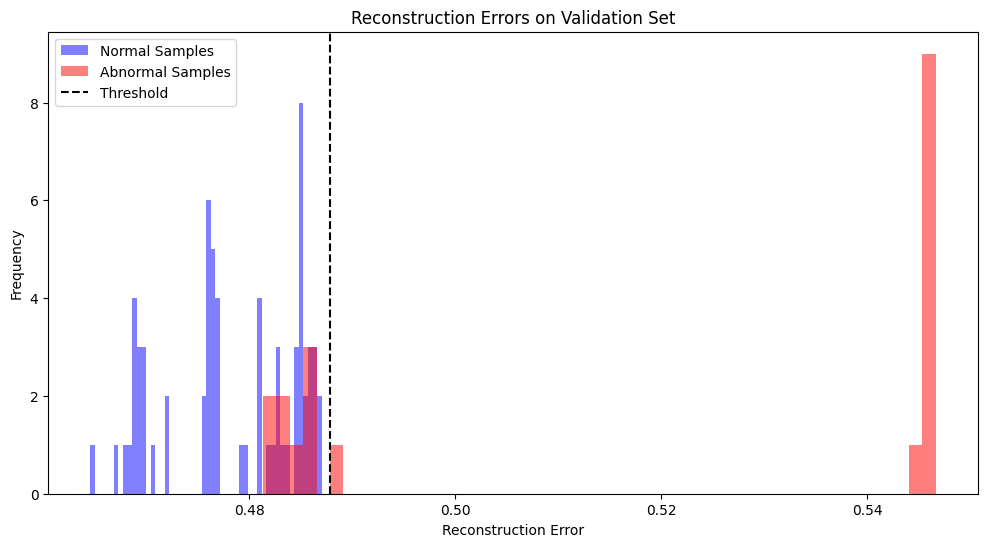

Best Threshold = 0.481840, Best F1 Score = 0.5957
Evaluation on Test Set:
Accuracy = 0.7816091954022989
Precision = 0.4666666666666667
Recall = 0.8235294117647058
F1 Score = 0.5957446808510638
Confusion Matrix:
 [[54 16]
 [ 3 14]]
Fold 4
Epoch 1/15, Loss: 0.917591
Epoch 2/15, Loss: 0.875210
Epoch 3/15, Loss: 0.782130
Epoch 4/15, Loss: 0.638153
Epoch 5/15, Loss: 0.537635
Epoch 6/15, Loss: 0.509979
Epoch 7/15, Loss: 0.503206
Epoch 8/15, Loss: 0.500655
Epoch 9/15, Loss: 0.499493
Epoch 10/15, Loss: 0.498827
Epoch 11/15, Loss: 0.498466
Epoch 12/15, Loss: 0.498219
Epoch 13/15, Loss: 0.498013
Epoch 14/15, Loss: 0.497944
Epoch 15/15, Loss: 0.497776
Best threshold: 0.48472903352795227, Best F1 Score: 0.8571428571428571


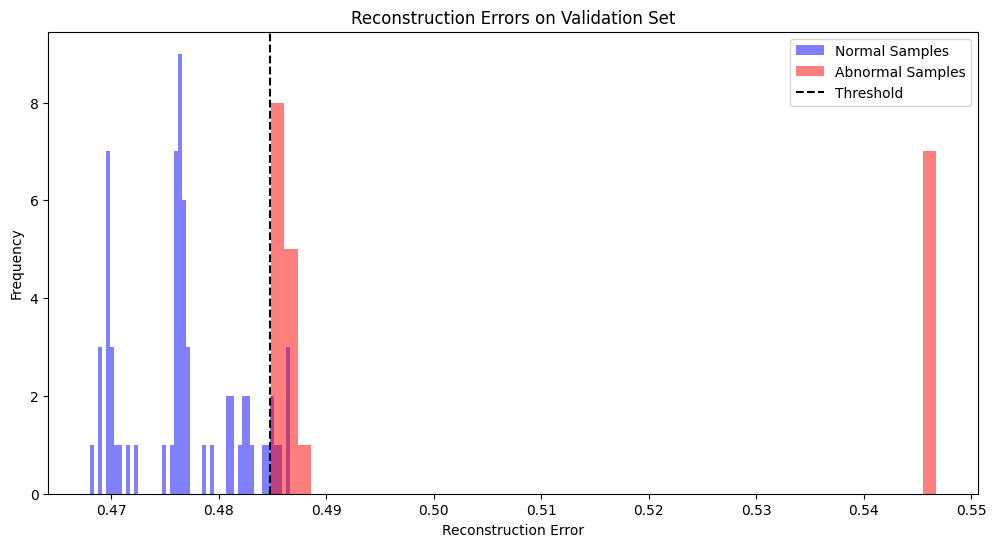

Best Threshold = 0.479091, Best F1 Score = 0.5660
Evaluation on Test Set:
Accuracy = 0.735632183908046
Precision = 0.39473684210526316
Recall = 1.0
F1 Score = 0.5660377358490566
Confusion Matrix:
 [[49 23]
 [ 0 15]]
Fold 5
Epoch 1/15, Loss: 0.918185
Epoch 2/15, Loss: 0.878158
Epoch 3/15, Loss: 0.783445
Epoch 4/15, Loss: 0.623908
Epoch 5/15, Loss: 0.526648
Epoch 6/15, Loss: 0.507011
Epoch 7/15, Loss: 0.502007
Epoch 8/15, Loss: 0.499850
Epoch 9/15, Loss: 0.498671
Epoch 10/15, Loss: 0.498115
Epoch 11/15, Loss: 0.497798
Epoch 12/15, Loss: 0.497574
Epoch 13/15, Loss: 0.497423
Epoch 14/15, Loss: 0.497473
Epoch 15/15, Loss: 0.497343
Best threshold: 0.48559727271397907, Best F1 Score: 0.7111111111111111


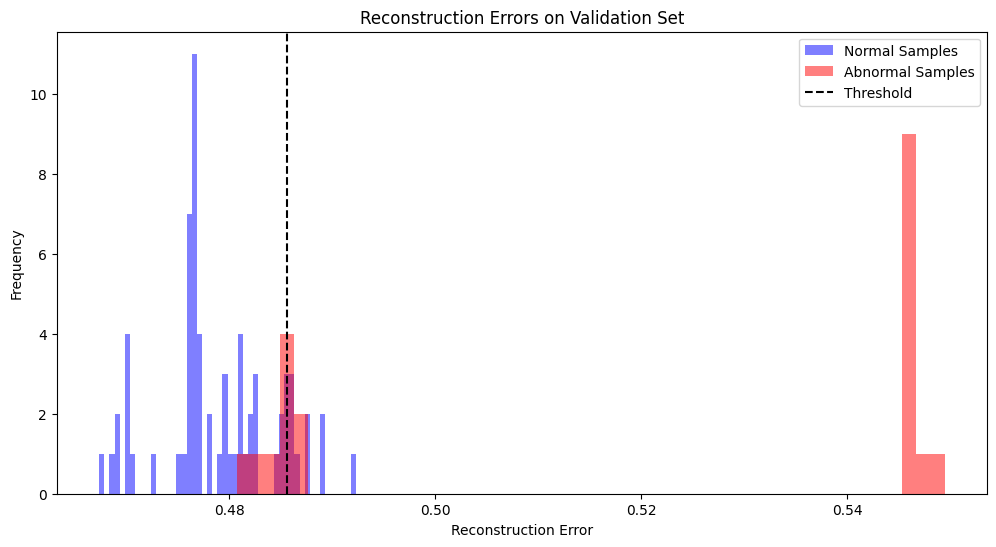

Best Threshold = 0.487725, Best F1 Score = 0.6667
Evaluation on Test Set:
Accuracy = 0.9080459770114943
Precision = 1.0
Recall = 0.5
F1 Score = 0.6666666666666666
Confusion Matrix:
 [[71  0]
 [ 8  8]]


In [6]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features, label)):
    
    print(f"Fold {fold + 1}")
    
    # Get full fold data
    fold_data, fold_labels = features[train_idx], label[train_idx]
    val_data, val_labels = features[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))

    # Train autoencoder on the training fold
    model = train_autoencoder(X_train[y_train == 0], epochs=15, batch_size=32)

    # Evaluate on validation fold
    val_errors_normal = compute_reconstruction_loss(model, X_val[y_val == 0])
    val_errors_abnormal = compute_reconstruction_loss(model, X_val[y_val == 1])
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    

    val_errors_test = compute_reconstruction_loss(model, X_test)
    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))


In [11]:
np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

(0.8123563218390805,
 0.5094832535885168,
 0.5327115583075336,
 0.47873977147555646)

# Observation:












Average scores:

Accuracy = 0.8123563218390805

Precision = 0.5094832535885168

Recall = 0.5327115583075336

F1 Score = 0.5327115583075336



Best:

Accuracy = 0.8636363636363636

Precision = 0.6842105263157895

Recall = 0.6842105263157895

F1 Score = 0.6842105263157895

Confusion Matrix:

 [[63  6]

 [ 6 13]]

